## Расчет количества преподавателей в зависимости от количества учеников и сезона

В этом варианте модель регрессии строится по данным о количестве учеников, затем количество преподавателей рассчитывается в зависимости от сезона (ежемесячно). Применимость метода в том, что он косвенно учитывает и частоту занятий

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv #вычисление обратной матрицы
from sklearn.metrics import mean_absolute_error #поиск средней ошибки в абсолютном и квадратичном смысле

data = pd.read_csv("classes.csv")

В таблице full_data представлены: количество преподавателей и учеников за каждый месяц, их колличественное
отношение

In [3]:
data['start_at']= pd.to_datetime(data['start_at']) 
#data.sort_values(by = "start_at", inplace = True)
data['year'] = data['start_at'].dt.year
data['month'] = data['start_at'].dt.month
full_data = data.groupby(['year', 'month'])['teacher_id','student_id'].nunique()

In [4]:
full_data = pd.DataFrame(full_data)
full_data.columns = ["count_teachers", "count_students"]
full_data["relation"] = 0
full_data["relation"] = full_data["relation"].astype('float64')
for i in range (1, 25):
    full_data.iloc[i, full_data.columns.get_loc('relation')] = full_data["count_students"][i]/full_data["count_teachers"][i-1]
    
full_data

count_teachers  count_students  relation
year month                                          
2017 9                1207            7084  0.000000
     10               1273            7934  6.573322
     11               1463            8832  6.937942
     12               1693           10435  7.132604
2018 1                1806           10340  6.107501
     2                2088           11723  6.491141
     3                2488           14645  7.013889
     4                2854           16221  6.519695
     5                3256           19428  6.807288
     6                3517           20816  6.393120
     7                3739           20990  5.968155
     8                4009           21709  5.806098
     9                4299           22864  5.703168
     10               4631           26637  6.196092
     11               4774           29633  6.398834
     12               4883           31768  6.654378
2019 1                5153           31152  6.379685
     2                5681           34275  6.651465
     3                6197           40261  7.086957
     4                6644           42981  6.935775
     5                7024           47087  7.087146
     6                7154           46351  6.598946
     7                7303           46333  6.476517
     8                7776           47973  6.568944
     9                8252           49486  6.363940

Далее идет построение самой модели регрессии, оценивающей количество учеников

In [5]:
Y_true = full_data['count_students']
Y_true.index = range(25)

Y = np.matrix(Y_true).T
Y_train = Y[:-1]
A = np.matrix(np.concatenate((np.ones(shape = (Y_true.size-1, 1), dtype = int), np.arange(0,Y_true.size-1).reshape(Y_true.size-1,1)), axis=1))
#один месяц отрезаем для проверки

In [6]:
tetta = np.dot(np.dot(inv(np.dot(A.T,A)),A.T), Y_train)
a0 = float(tetta[0,0])
k = float(tetta[1,0])
print("Оценки параметров: a = {0}, k = {1} ".format(a0, k))

Оценки параметров: a = 3516.750000000002, k = 1931.413043478261 


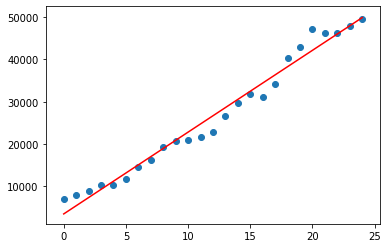

In [7]:
x = np.linspace(0, Y_train.size,Y_train.size + 1)
Y_pred = a0 + x * k

plt.plot(x, Y_pred, '-r')
plt.scatter(Y_true.index, Y_true)
plt.show()

На графике видно, что количество учеников имеет более явную сезонную составляющую, нежели у преподавателей

In [8]:
print("Ошибка количества преподавателей на тестовом месяце: ", (a0 + Y_train.size * k)/full_data.loc[2018,9].relation - full_data.loc[2019,9].count_teachers)

Ошибка количества преподавателей на тестовом месяце:  492.37929239434743


In [9]:
print("Предсказанное количество преподавателей в следующем (10ом) месяце:\n", (a0 + (Y_train.size + 1)*k)/full_data.loc[2018,10].relation)

Предсказанное количество преподавателей в следующем (10ом) месяце:
 8360.443184210913


### Оценка точности модели

In [13]:
j = 5
res = 0
for i in range(20,25):
    res = res + abs(full_data.loc[2019,j].count_teachers - Y_pred[i]/full_data.loc[2018,j].relation)
    j = j + 1
print("Средняя абсолютная ошибка за последние пять месяцев: ", res/5)

Средняя абсолютная ошибка за последние пять месяцев:  494.2924284626697
